In [622]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

## Goal: To use data analytics to determine the value generated by each player in every season of NBA basketball played since 2000 and award that player the Most Valuable Player award.

#### We hope to remove media biases and narratives and simply present the player that statistically added the most value to their team each year.

In [623]:
#pull in all our merged datasets
player_stats = pd.read_csv("/Users/sa12/Documents/Repositories/nba-stats/data/player_stats/merge2000-2024.csv").drop_duplicates()
adv_player_stats = pd.read_csv("/Users/sa12/Documents/Repositories/nba-stats/data/advanced_stats/merge2000-2024.csv").drop_duplicates()
mvps = pd.read_csv("/Users/sa12/Documents/Repositories/nba-stats/data/MVPs.csv").drop_duplicates()
team_stats = pd.read_csv("/Users/sa12/Documents/Repositories/nba-stats/data/team_stats/merge2000-2024.csv").drop_duplicates()

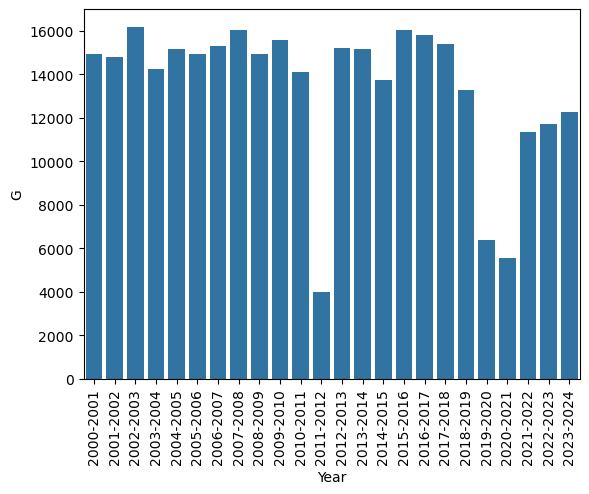

In [624]:
#In 2022, the NBA introduced a rule mandating that players play 65 games to be eligible for end of season awards.
#I am going to apply this criteria to historical data to see how it effects conclusions 

#First line of code removes rows double-counting player's stats who were traded mid-season
player_stats = player_stats[player_stats["Team"].str.contains("2TM") == False]
#next line filters out ineligible players
eligible_players = player_stats[player_stats["G"] >= 65]
#repeat the process for the advanced stats
adv_player_stats = adv_player_stats[adv_player_stats["Team"].str.contains("2TM") == False]
adv_eligible_players = adv_player_stats[adv_player_stats["G"] >= 65]
#I want to plot to see if the values are consistant throughout the years
games_played = eligible_players.groupby(eligible_players["Year"])["G"].sum()
sns.barplot(games_played)
plt.xticks(rotation=90)
plt.show()

We notice a sharp decline in the 2011-2012 season. Research shows this was due to only playing 66 games due to a lockout. Future analysis must account this.

We also begin to see a downward trend in 2019-2021. This is likely due to covid restrictions. However, even after restrictions were lifted, number of games played over 65 is signifcantly lower than previously. This is likely what prompted the league to change the rules about eligibility after the 2022-2023 season.

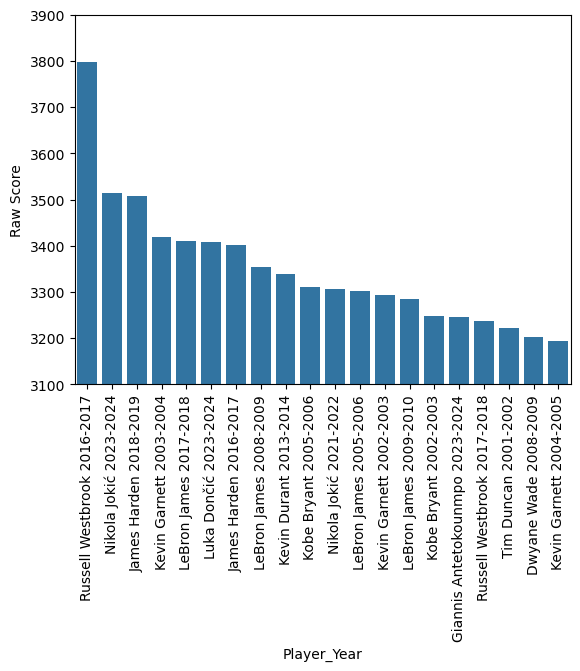

In [625]:
raw_value = pd.DataFrame(eligible_players["Player"])
#dataframe of all eligible players
raw_value["Year"] = eligible_players["Year"]
#create an aggregate number based on the sum of traditional counting stats subtracted by the sum of traditional negative stats
raw_value["Raw Score"] = eligible_players["PTS"] + eligible_players["AST"] + eligible_players["TRB"] + eligible_players["BLK"] + eligible_players["STL"] - eligible_players["PF"] - eligible_players["TOV"]
#Raw Score = Points + Assists + Rebounds + Blocks + Steals - Fouls - Turnovers
raw_value["Player_Year"] = raw_value["Player"] + " " + raw_value["Year"]
#Creating a column concatinating Player & Year in order to differentiate individual seasons within the data
raw_value = raw_value.set_index("Player_Year")
#Setting the index to lock Player_Year to the values, than sorting in decending order
raw_value = raw_value.sort_values("Raw Score", ascending=False)
#Now we can view our top 20 seasons in "Raw Value"
top_raw_value = raw_value.head(20)
sns.barplot(top_raw_value, x=top_raw_value.index, y=top_raw_value["Raw Score"])
plt.ylim(3100,3900)
plt.xticks(rotation=90)
plt.show()

Raw Value is a measure I created adding together the positive stats a player can accumulate during a game: Scoring a basket, assisting a basket, rebounding a missed shot, stealing the ball, and blocking a shot. It is then subtracted by the negative stats a player can get during the game: turning the ball over to the other team, and fouling an opposing player ginving them free throws. I intentionally excluded shooting percentages because that is a measure of effciency, something I will evaluate later.

#### I believe this is an accurate measure of the raw statistical value the player provided over the course of the season.

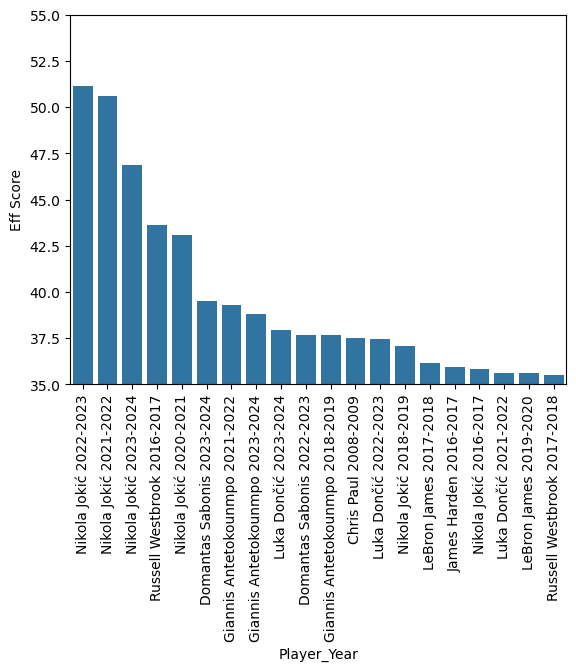

In [626]:
adv_value = pd.DataFrame(adv_eligible_players["Player"])
adv_value["Year"] = adv_eligible_players["Year"]
#Creating a score with effciency percentages that mirror the raw values and accurately weighting each one
#All % (except TS%) are the total of all opprotunities that ended with the player counting the stat
# Eff Score = (AST% + ORB% + DRB% + BLK% + STL%) * TS% [TS% = PTS/2(FGA+(.44*FGA))]
adv_value["Eff Score"] = (adv_eligible_players["AST%"] + adv_eligible_players["ORB%"] + adv_eligible_players["DRB%"] + adv_eligible_players["BLK%"] + adv_eligible_players["STL%"] - adv_eligible_players["TOV%"]) * adv_eligible_players["TS%"]
adv_value["Player_Year"] = adv_value["Player"] + " " + adv_value["Year"]
adv_value = adv_value.set_index("Player_Year")
#Locking the score to the player
#Sort Eff Score high to low
adv_value_sorted = adv_value.sort_values("Eff Score", ascending=False)
top_adv_value_sorted = adv_value_sorted.head(20)
#created a top 20 variable than plot the results
sns.barplot(top_adv_value_sorted, x=top_adv_value_sorted.index, y=top_adv_value_sorted["Eff Score"])
plt.ylim(35,55)
plt.xticks(rotation=90)
plt.show()

Calculating a players effciency was tricky. The concept is: by using the measures collected regarding percentage of opprotunities presented vs. the collection of those stats that directly relate to the values used in calculating raw score, we can see exactly how effcient a player was in collecting their raw score.

AST% (Assist Percentage) – The percentage of teammates' made field goals that a player assisted while on the court

ORB% (Offensive Rebound Percentage) – The percentage of available offensive 
rebounds a player grabs while on the floor. 

DRB% (Defensive Rebound Percentage) – The percentage of available defensive 
rebounds a player grabs while on the floor.

SEPERATING OFFENSIVE AND DEFENSIVE REBOUNDS IS CRITICAL IN ACCURATELY REPRESENTING REBOUNDING EFFCIENCY IN THE CALCULATION COMPARED TO THE WEIGHT OF REBOUNDS IN RAW SCORE CALCULATION

STL% (Steal Percentage) – The percentage of opponent possessions where the player records a steal. 

BLK% (Block Percentage) – The percentage of opponent two-point shot attempts that the player blocks.

SUBTRACTED BY

TOV% (Turnover Percentage) – The percentage of a player's possessions that result in a turnover.

THERE IS NOT A MEASURE FOR FOUL%. IT WOULD BE INCLUDED HERE IF IT EXISTED

#### I BEILEVE THIS IS AN ACCURATE REPRESNETATION OF HOW EFFCIENT A PLAYER WAS IN COLLECTING THE STATS MEASURED IN RAW SCORE. THEREFORE, IT CAN BE USED AS A SECONDARY METRIC TO PROVIDE CONTEXT TO OUR RAW SCORE METRIC

Two qualitative variables that need to be compared against one another? Let's get a-scattering!

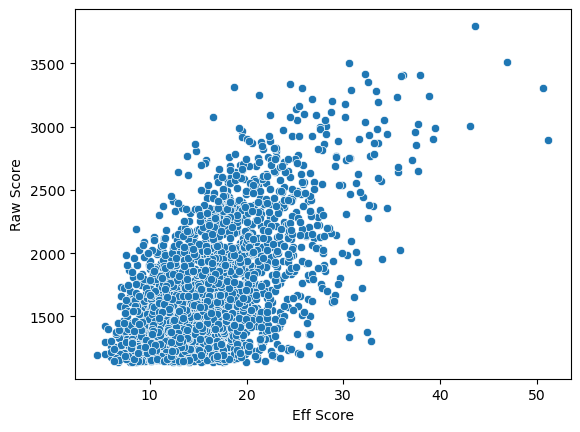

In [627]:
#First merge together both of the dataframes we have created
Full_Value_Matrix = pd.merge(adv_value, raw_value, on=["Player_Year", "Player", "Year"])
#Now we want to reduce the size of our dataset. Cutting off at the median is a good way
mid_Eff_Score = Full_Value_Matrix["Eff Score"].median()
mid_Raw_Score = Full_Value_Matrix["Raw Score"].median()
#boolean index the values above the median
Value_Matrix = Full_Value_Matrix[Full_Value_Matrix["Eff Score"] > mid_Eff_Score]
Value_Matrix = Full_Value_Matrix[Full_Value_Matrix["Raw Score"] > mid_Raw_Score]
#plot
sns.scatterplot(Value_Matrix, x="Eff Score", y="Raw Score")
plt.show()

Every above average season in the last 25 years. This lets us identify how to filter the data to see only the upper right portion. There are no significant outliers to account for, so we'll make the min eff score 30, while the min raw score is 3100.

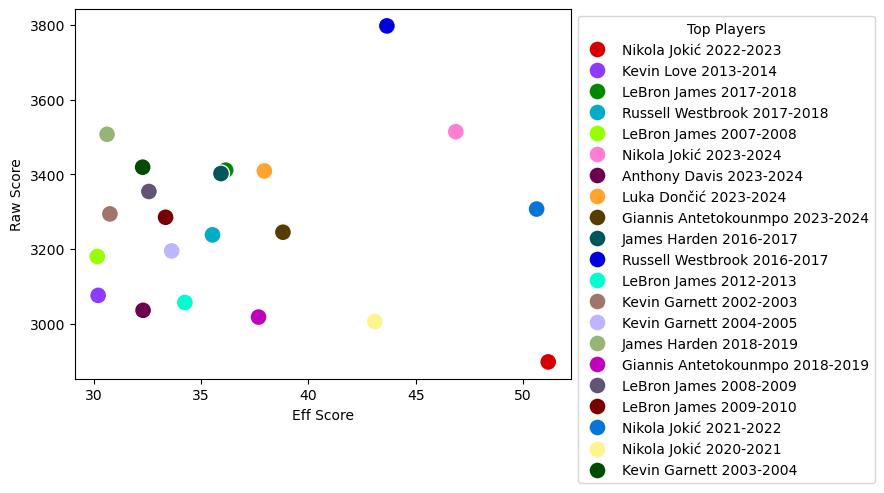

In [628]:
#create a new Value Matrix dataframe
Top_Value_Matrix = Value_Matrix
#remove players who do not appear in the upper right quadrant of the scatterplot
Top_Value_Matrix = Value_Matrix[((Value_Matrix["Eff Score"] > 30) & (Value_Matrix["Raw Score"] > 3000))|(Value_Matrix["Eff Score"] > 40)]
#creat a new pallete of colors to diffentiate between players
palette = sns.color_palette(cc.glasbey, n_colors=21)
#number of colors = 15 because that is the number of values we have filtered down to
sns.scatterplot(Top_Value_Matrix, x=Top_Value_Matrix["Eff Score"], y=Top_Value_Matrix["Raw Score"], hue=Top_Value_Matrix.index, s=150, palette=palette)
plt.legend(title="Top Players", bbox_to_anchor=(1,1), loc="upper left")
plt.show()

The 21 Greatest seasons of all time according to my matrix. Interestingly, 4 of those seasons happened just last year. From this we can determine a few things, if the player is the only one represented from that year, he is that years MVP. If the player is clearly higher and rightword of another player from that year, they produced more value. Luckly this chart produced very clear results aside from 2018-2019.

Luckly, this chart produced very clear results:
##### MVP 2002-2003: Kevin Garnett
##### MVP 2003-2004: Kevin Garnett
##### MVP 2004-2005: Kevin Garnett
##### MVP 2007-2008: LeBron James
##### MVP 2008-2009: LeBron James
##### MVP 2009-2010: LeBron James
##### MVP 2012-2013: LeBron James
##### MVP 2013-2014: Kevin Love 
##### MVP 2016-2017: Russell Westbrook
##### MVP 2017-2018: LeBron James
##### MVP 2020-2021: Nikola Jokic
##### MVP 2021-2022: Nikola Jokic
##### MVP 2022-2023: Nikola Jokic
##### MVP 2023-2024: Nikola Jokic

That means the seasons we need to take a closer look at are:

2000-2001

2001-2002

2005-2006

2006-2007

2010-2011

2011-2012 lockout

2014-2015

2015-2016

2019-2020 covid

These two year windows without representation are interesting to think about. It also means than I can evaluate these windows together and still produce meaningful results.

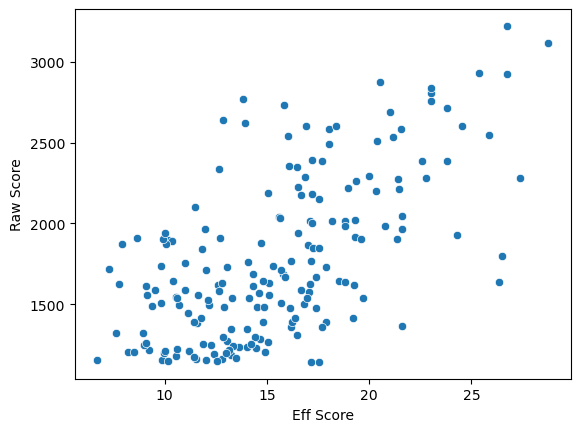

In [629]:
#create a new df to modify and filter the years we want
Value_Matrix_2000_2002 = Value_Matrix[(Value_Matrix["Year"] == "2000-2001")|(Value_Matrix["Year"] == "2001-2002")]
#plot to visualize where to cut
sns.scatterplot(Value_Matrix_2000_2002, x=Value_Matrix_2000_2002["Eff Score"], y=Value_Matrix_2000_2002["Raw Score"])
plt.show()

Looks like the best place to chop the data is around 20 Eff Score and 2500 Raw Score. Going to include a second measure to cature the outlier in efficiency 

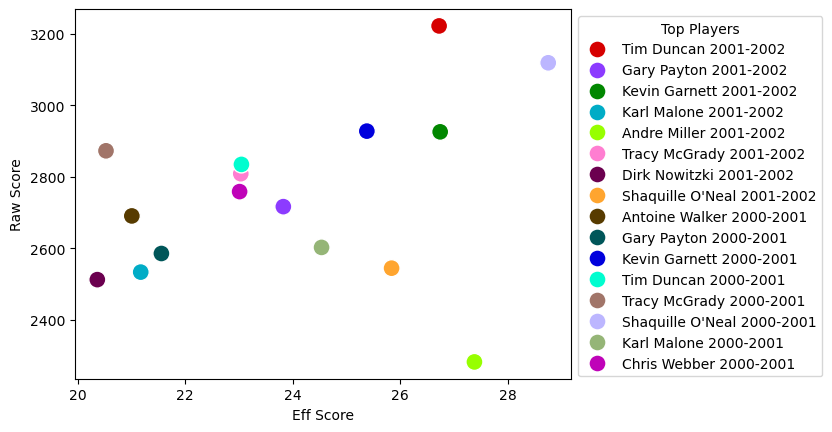

In [692]:
#make the cut
Top_Value_2000_2002 = Value_Matrix_2000_2002[((Value_Matrix_2000_2002["Eff Score"] > 20) & (Value_Matrix_2000_2002["Raw Score"] > 2500))|(Value_Matrix_2000_2002["Eff Score"] > 27)]
#needed more colors to accuratley visualize the data so I created a new pallete
palette = sns.color_palette(cc.glasbey, n_colors=16)
#plot top right
sns.scatterplot(Top_Value_2000_2002, x=Top_Value_2000_2002["Eff Score"], y=Top_Value_2000_2002["Raw Score"], hue=Top_Value_2000_2002.index, s=150, palette=palette)
plt.legend(title="Top Players", bbox_to_anchor=(1,1), loc="upper left")
plt.show()

The results here are extremly straightforward, with 2 player dominating respective years. This is also the first time the league's actual MVP, Allen Iverson, is not represented. This may indicate other factors at play when the league considers value, and my matrix may need more refinment in the future to better reflect reality.
##### MVP 2000-2001: Shaquille O'Neal
##### MVP 2001-2002: Tim Duncan

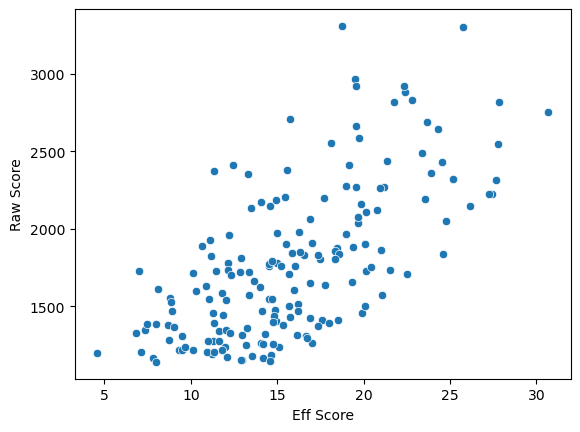

In [631]:
#create a df to modify and filter the years we want
Value_Matrix_2005_2007 = Value_Matrix[(Value_Matrix["Year"] == "2005-2006")|(Value_Matrix["Year"] == "2006-2007")]
#plot to visualize where to cut
sns.scatterplot(Value_Matrix_2005_2007, x=Value_Matrix_2005_2007["Eff Score"], y=Value_Matrix_2005_2007["Raw Score"])
plt.show()

Roughly 2500 for the Raw Score again. I am going to try to inlude the ineffcient Raw Score Outlier when filtering the ineffciency score. It is slightly less than 20.

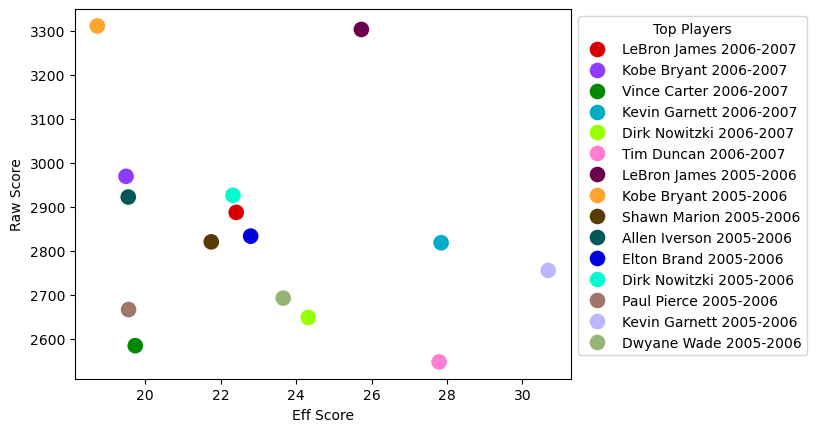

In [646]:
#make the cut at 18.5
Top_Value_2005_2007 = Value_Matrix_2005_2007[(Value_Matrix_2005_2007["Eff Score"] > 18.5) & (Value_Matrix_2005_2007["Raw Score"] > 2500)]
#create a new palette to stop getting a stupid warning about there being more colors than needed. DUMB
palette = sns.color_palette(cc.glasbey, n_colors=15)
sns.scatterplot(Top_Value_2005_2007, x=Top_Value_2005_2007["Eff Score"], y=Top_Value_2005_2007["Raw Score"], hue=Top_Value_2005_2007.index, s=150, palette=palette)
plt.legend(title="Top Players", bbox_to_anchor=(1,1), loc="upper left")
plt.show()

This is my first large dilemma. In both 2005-2006 and 2006-2007, 3 players stand out as having outlier seasons, but how to compare which of these season is MORE valuable. I have to compare LeBron James, Kevin Garnett, and Kobe Bryant. All three had outlier seasons in 2005-2006. 2006-2007 they are closer to the pack but are still above their contemporaries.

What I will do is create 2 ratios comparing both Kobe and KG against the league median Eff Scores and Raw Scores collected earlier, than add the together. 

/var/folders/t3/tq1z8cy535bck4xjwkvc0_xh0000gn/T/ipykernel_7622/619788638.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Kobe_2005_2007["Ratio"] = (Kobe_2005_2007["Eff Score"]/mid_Eff_Score) + (Kobe_2005_2007["Raw Score"]/mid_Raw_Score)
/var/folders/t3/tq1z8cy535bck4xjwkvc0_xh0000gn/T/ipykernel_7622/619788638.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KG_2005_2007["Ratio"] = (KG_2005_2007["Eff Score"]/mid_Eff_Score) + (KG_2005_2007["Raw Score"]/mid_Raw_Score)
/var/folders/t3/tq1z8cy535bck4xjw

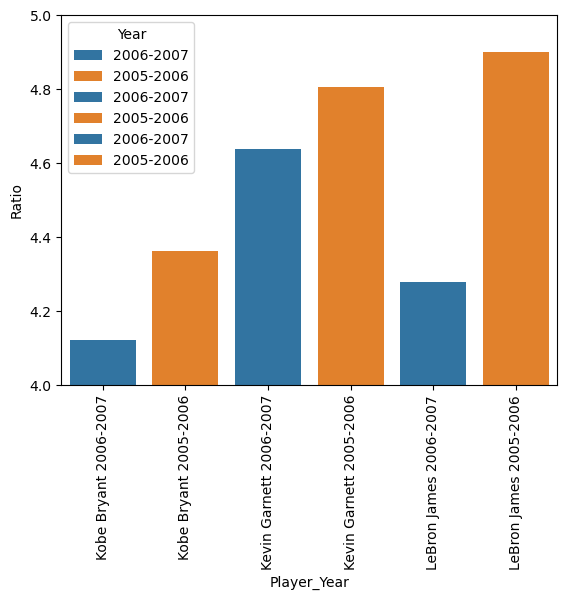

In [718]:
#First seperate the rows I need for Kobe Bryant
Kobe_2005_2007 = Top_Value_2005_2007[(Top_Value_2005_2007["Player"]=="Kobe Bryant")&((Top_Value_2005_2007["Year"] == "2005-2006")|(Top_Value_2005_2007["Year"] == "2006-2007"))]
#And then Kevin Garnett, nicknamed KG
KG_2005_2007 = Top_Value_2005_2007[(Top_Value_2005_2007["Player"]=="Kevin Garnett")&((Top_Value_2005_2007["Year"] == "2005-2006")|(Top_Value_2005_2007["Year"] == "2006-2007"))]
#finally for LeBron James
Lebron_2005_2007 = Top_Value_2005_2007[(Top_Value_2005_2007["Player"]=="LeBron James")&((Top_Value_2005_2007["Year"] == "2005-2006")|(Top_Value_2005_2007["Year"] == "2006-2007"))]
#Dividing the player scores by the median lets use evaluate how far each players collective stats deviate from the median. 
#simply subtracting the numbers would weigh the raw score much heavier than effciency
Kobe_2005_2007["Ratio"] = (Kobe_2005_2007["Eff Score"]/mid_Eff_Score) + (Kobe_2005_2007["Raw Score"]/mid_Raw_Score)
#create our "Ratio" value to compare the seasons distance from the median
KG_2005_2007["Ratio"] = (KG_2005_2007["Eff Score"]/mid_Eff_Score) + (KG_2005_2007["Raw Score"]/mid_Raw_Score)
Lebron_2005_2007["Ratio"] =(Lebron_2005_2007["Eff Score"]/mid_Eff_Score) + (Lebron_2005_2007["Raw Score"]/mid_Raw_Score)
sns.barplot(Kobe_2005_2007, x="Player_Year", y="Ratio",hue="Year")
sns.barplot(KG_2005_2007, x="Player_Year", y="Ratio",hue="Year")
sns.barplot(Lebron_2005_2007, x="Player_Year", y="Ratio",hue="Year")
plt.ylim(4,5)
plt.xticks(rotation=90)
plt.show()
#THE DATA IS ASSIGNING CORRECTLY SO IM IGNORING THE WARNING

The idea is that the greater the difference of the players value vs. the median value, the larger the result of the equation is. Meaning, the more extraodinary they performed that year. By adding these ratios together, we can actually determine how much relative value over average that the player added through raw number and effciency even though the metrics are not directly comperable.

2005-2006 was extremly close but it looks like Lebron won out.

2006-2007 goes back to KG.

##### MVP 2005-2006 LeBron James
##### MVP 2006-2007 Kevin Garnett

I would like to evaluate 2010-2011 and 2011-2012 together, however, the lockout in 2011-2012 makes this impossible. I need to evaluate this seperately

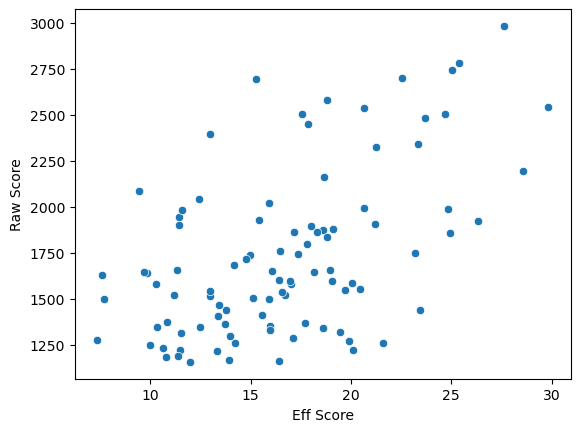

In [634]:
#create a new df to modify and filter the years we want
Value_Matrix_2010_2011 = Value_Matrix[(Value_Matrix["Year"] == "2010-2011")]
#plot to visualize where to cut
sns.scatterplot(Value_Matrix_2010_2011, x=Value_Matrix_2010_2011["Eff Score"], y=Value_Matrix_2010_2011["Raw Score"])
plt.show()

Cut off: Eff Score 20 and Raw Score 2000

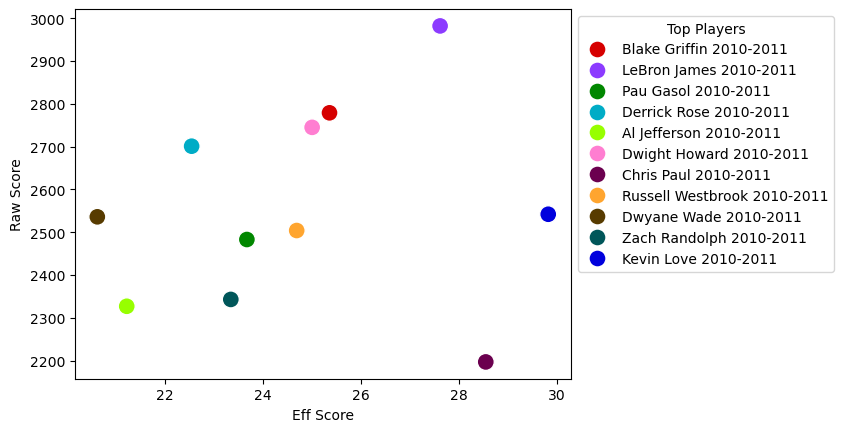

In [647]:
Top_Value_2010_2011 = Value_Matrix_2010_2011[(Value_Matrix_2010_2011["Eff Score"] > 20) & (Value_Matrix_2010_2011["Raw Score"] > 2000)]
#create a new palette to stop getting a stupid warning about there being more colors than needed. STILL DUMB
palette = sns.color_palette(cc.glasbey, n_colors=11)
sns.scatterplot(Top_Value_2010_2011, x=Top_Value_2010_2011["Eff Score"], y=Top_Value_2010_2011["Raw Score"], hue=Top_Value_2010_2011.index, s=150, palette=palette)
plt.legend(title="Top Players", bbox_to_anchor=(1,1), loc="upper left")
plt.show()

LeBron James should win this MVP. However, I do believe it is worthwhile to evaluate his and Kevin Love's season to see if Eff Score is being overrepresented in our evaluation.

/var/folders/t3/tq1z8cy535bck4xjwkvc0_xh0000gn/T/ipykernel_7622/3440982918.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Love_Ratio["Ratio"] = (Love_2010_2011["Eff Score"]/mid_Eff_Score) + (Love_2010_2011["Raw Score"]/mid_Raw_Score)
/var/folders/t3/tq1z8cy535bck4xjwkvc0_xh0000gn/T/ipykernel_7622/3440982918.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LeBron_Ratio["Ratio"] =(Lebron_2010_2011["Eff Score"]/mid_Eff_Score) + (Lebron_2010_2011["Raw Score"]/mid_Raw_Score)


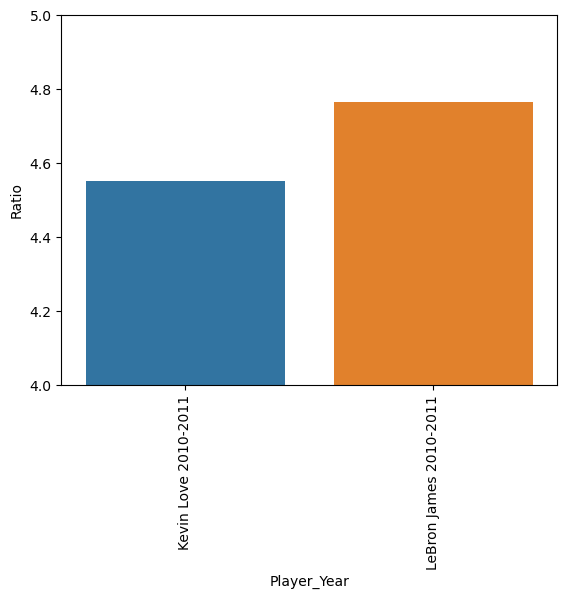

In [636]:
#pull out K Love's data
Love_2010_2011 = Top_Value_2010_2011[(Top_Value_2010_2011["Player"]=="Kevin Love")]
#same for LeBron James
Lebron_2010_2011 = Top_Value_2010_2011[(Top_Value_2010_2011["Player"]=="LeBron James")]
#Dividing the player scores by the median lets use evaluate how far each players collective stats deviate from the median. 
#simply subtracting the numbers would weigh the raw score much heavier than effciency
#create our "Ratio" value to compare the seasons distance from the median
Love_2010_2011["Ratio"] = (Love_2010_2011["Eff Score"]/mid_Eff_Score) + (Love_2010_2011["Raw Score"]/mid_Raw_Score)
Lebron_2010_2011["Ratio"] =(Lebron_2010_2011["Eff Score"]/mid_Eff_Score) + (Lebron_2010_2011["Raw Score"]/mid_Raw_Score)
#plot df seprately, only 2 values means no reason for hue
sns.barplot(Love_2010_2011, x="Player_Year", y="Ratio")
sns.barplot(Lebron_2010_2011, x="Player_Year", y="Ratio")
#reduce range of y to better visulize differences
plt.ylim(4,5)
plt.xticks(rotation=90)
plt.show()
#THE DATA IS ASSIGNING CORRECTLY SO IM IGNORING THE WARNING

Phew. LeBron was evaluated as MVP and this leads credibility to our testing. 
##### MVP 2010-2011 LeBron James

2011-2012 not only need to be evaluated alone, but because the season was only 66 games the entire framework by which we judged eligibility must be reevaluated. A normal season is 82 games. The 65 game requirement for eligibility is roughly 79% of games in a season. 79% of games in 2011-2012 would be 52 games. Lets resample from the start and redefine elgibility this year.

/var/folders/t3/tq1z8cy535bck4xjwkvc0_xh0000gn/T/ipykernel_7622/1224616443.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_stats_2011_2012["Raw Score"] = player_stats_2011_2012["PTS"] + player_stats_2011_2012["AST"] + player_stats_2011_2012["TRB"] + player_stats_2011_2012["BLK"] + player_stats_2011_2012["STL"] - player_stats_2011_2012["PF"] - player_stats_2011_2012["TOV"]
/var/folders/t3/tq1z8cy535bck4xjwkvc0_xh0000gn/T/ipykernel_7622/1224616443.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


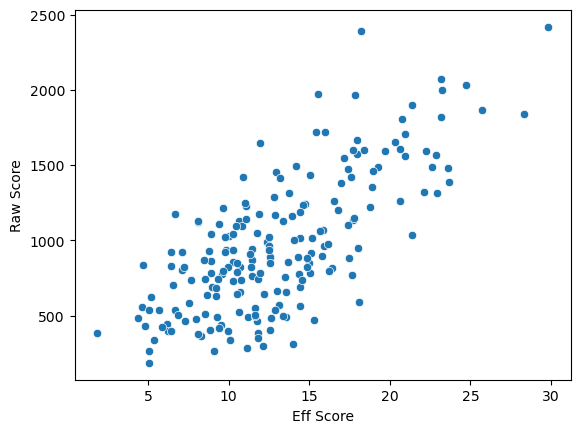

In [691]:
#filter for year and eligibility
player_stats_2011_2012 = player_stats[(player_stats["Year"] == "2011-2012")&(player_stats["G"] > 52)]
#recalculate raw score as a column in the df
player_stats_2011_2012["Raw Score"] = player_stats_2011_2012["PTS"] + player_stats_2011_2012["AST"] + player_stats_2011_2012["TRB"] + player_stats_2011_2012["BLK"] + player_stats_2011_2012["STL"] - player_stats_2011_2012["PF"] - player_stats_2011_2012["TOV"]
#defining what columns i want
keep_cols = ["Player","Raw Score"]
#removing those I don't for clean merge
player_stats_2011_2012 = player_stats_2011_2012[keep_cols]
#repeat the process for adv stats and Eff Score
adv_player_stats_2011_2012 = adv_player_stats[(adv_player_stats["Year"] == "2011-2012")&(adv_player_stats["G"] > 52)]
adv_player_stats_2011_2012["Eff Score"] = (adv_player_stats_2011_2012["AST%"] + adv_player_stats_2011_2012["ORB%"] + adv_player_stats_2011_2012["DRB%"] + adv_player_stats_2011_2012["BLK%"] + adv_player_stats_2011_2012["STL%"] - adv_player_stats_2011_2012["TOV%"]) * adv_player_stats_2011_2012["TS%"]
keep_cols_adv = ["Player","Eff Score"]
adv_player_stats_2011_2012 = adv_player_stats_2011_2012[keep_cols_adv]
#setting index
adv_player_stats_2011_2012.set_index("Player")
merge_2011_2012 = pd.merge(player_stats_2011_2012, adv_player_stats_2011_2012, on=["Player"])
sns.scatterplot(merge_2011_2012, x=merge_2011_2012["Eff Score"], y=merge_2011_2012["Raw Score"])
plt.show()
#THE DATA IS ASSIGNING CORRECTLY SO IM IGNORING THE WARNING

Much more empty chart than other years, covid did a number. The cutoff will be Eff Score 20 and Raw Score 1500, to capture that highly efficient season.

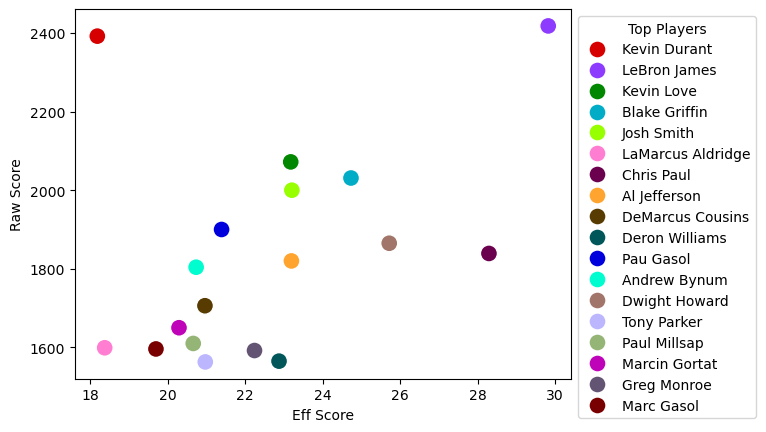

In [687]:
#make the cut
Top_Value_2011_2012 = merge_2011_2012[(merge_2011_2012["Eff Score"] > 18) & (merge_2011_2012["Raw Score"] > 1500)]
#new palette
palette = sns.color_palette(cc.glasbey, n_colors=18)
#plot
sns.scatterplot(Top_Value_2011_2012, x=Top_Value_2011_2012["Eff Score"], y=Top_Value_2011_2012["Raw Score"], hue=Top_Value_2011_2012["Player"], s=150, palette=palette)
plt.legend(title="Top Players", bbox_to_anchor=(1,1), loc="upper left")
plt.show()

Kevin Durant had a fantastic seson, but it didn't come close to LeBron. It should be noted that if I had kept the 65 game minimum, Lebron nor Chris Paul would qualify and he would run away with it.
##### MVP 2011-2012: LeBron James

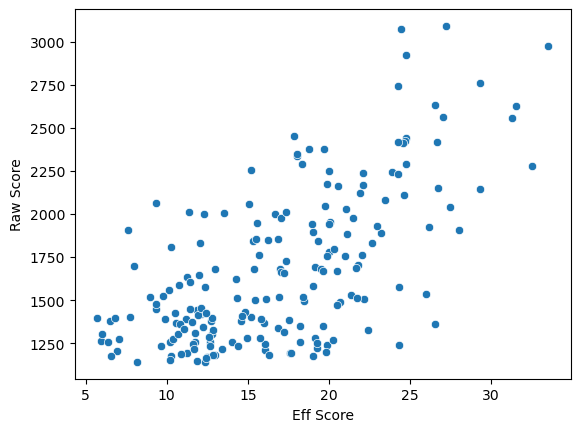

In [645]:
#create a new df to modify and filter for the years we want
Value_Matrix_2014_2016 = Value_Matrix[(Value_Matrix["Year"] == "2014-2015")|(Value_Matrix["Year"] == "2015-2016")]
#plot to visualize where to cut
sns.scatterplot(Value_Matrix_2014_2016, x=Value_Matrix_2014_2016["Eff Score"], y=Value_Matrix_2014_2016["Raw Score"])
plt.show()

Looks like a good cutoff to capture the far right values is Eff Score 24 and Raw Score 2200.

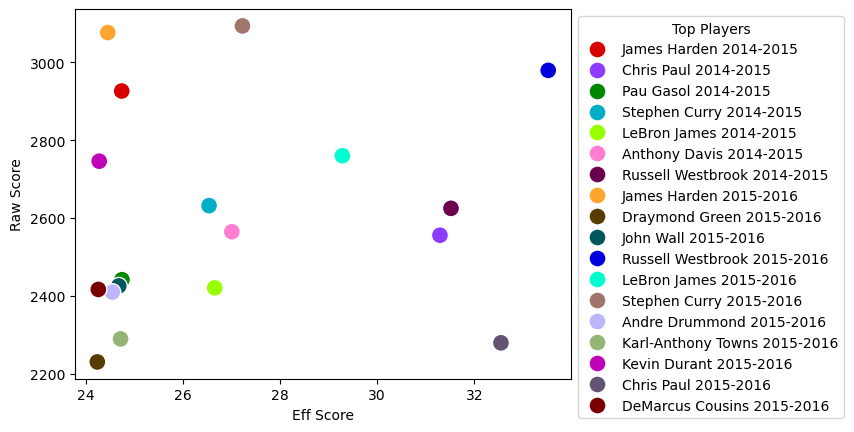

In [639]:
Top_Value_2014_2016 = Value_Matrix_2014_2016[(Value_Matrix_2014_2016["Eff Score"] > 24) & (Value_Matrix_2014_2016["Raw Score"] > 2200)]
sns.scatterplot(Top_Value_2014_2016, x=Top_Value_2014_2016["Eff Score"], y=Top_Value_2014_2016["Raw Score"], hue=Top_Value_2014_2016.index, s=150, palette=palette)
plt.legend(title="Top Players", bbox_to_anchor=(1,1), loc="upper left")
plt.show()

While it does look like the assumtion can be made that Russell Westbrook wins the 2015-2016 MVP, we can still run an analysis to confirm it because James Harden, Steph Curry, and Chris Paul also had excellent seasons. 2014-2015 is very close between 5 players: James Harden, Russell Westbrook, Chris Paul, Steph Curry, and Anthony Davis. These are the players we will evaluate.

/var/folders/t3/tq1z8cy535bck4xjwkvc0_xh0000gn/T/ipykernel_7622/2362262896.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Harden_2014_2016["Ratio"] = (Harden_2014_2016["Eff Score"]/mid_Eff_Score) + (Harden_2014_2016["Raw Score"]/mid_Raw_Score)
/var/folders/t3/tq1z8cy535bck4xjwkvc0_xh0000gn/T/ipykernel_7622/2362262896.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Curry_2014_2016["Ratio"] = (Curry_2014_2016["Eff Score"]/mid_Eff_Score) + (Curry_2014_2016["Raw Score"]/mid_Raw_Score)
/var/folders/t3

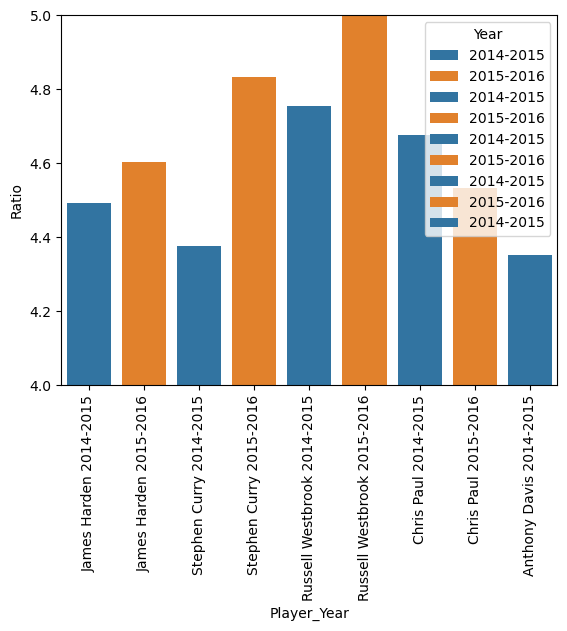

In [695]:
#First seperate the rows I need for James Harden
Harden_2014_2016 = Top_Value_2014_2016[(Top_Value_2014_2016["Player"]=="James Harden")&((Top_Value_2014_2016["Year"] == "2014-2015")|(Top_Value_2014_2016["Year"] == "2015-2016"))]
#And then Stephen Curry
Curry_2014_2016 = Top_Value_2014_2016[(Top_Value_2014_2016["Player"]=="Stephen Curry")&((Top_Value_2014_2016["Year"] == "2014-2015")|(Top_Value_2014_2016["Year"] == "2015-2016"))]
#Russell Westbrook
Westbrook_2014_2016 = Top_Value_2014_2016[(Top_Value_2014_2016["Player"]=="Russell Westbrook")&((Top_Value_2014_2016["Year"] == "2014-2015")|(Top_Value_2014_2016["Year"] == "2015-2016"))]
#ChrisPaul
Paul_2014_2016 = Top_Value_2014_2016[(Top_Value_2014_2016["Player"]=="Chris Paul")&((Top_Value_2014_2016["Year"] == "2014-2015")|(Top_Value_2014_2016["Year"] == "2015-2016"))]
#And finally Anthony Davis
Davis_2014_2016 = Top_Value_2014_2016[(Top_Value_2014_2016["Player"]=="Anthony Davis")&((Top_Value_2014_2016["Year"] == "2014-2015")|(Top_Value_2014_2016["Year"] == "2015-2016"))]
#Dividing the player scores by the median lets use evaluate how far each players collective stats deviate from the median. 
#create our "Ratio" value to compare combined distance from the median
Harden_2014_2016["Ratio"] = (Harden_2014_2016["Eff Score"]/mid_Eff_Score) + (Harden_2014_2016["Raw Score"]/mid_Raw_Score)
Curry_2014_2016["Ratio"] = (Curry_2014_2016["Eff Score"]/mid_Eff_Score) + (Curry_2014_2016["Raw Score"]/mid_Raw_Score)
Westbrook_2014_2016["Ratio"] = (Westbrook_2014_2016["Eff Score"]/mid_Eff_Score) + (Westbrook_2014_2016["Raw Score"]/mid_Raw_Score)
Paul_2014_2016["Ratio"] =(Paul_2014_2016["Eff Score"]/mid_Eff_Score) + (Paul_2014_2016["Raw Score"]/mid_Raw_Score)
Davis_2014_2016["Ratio"] =(Davis_2014_2016["Eff Score"]/mid_Eff_Score) + (Davis_2014_2016["Raw Score"]/mid_Raw_Score)
#plot each df seperatly and color the years differnty for easy evaluation
sns.barplot(Harden_2014_2016, x="Player_Year", y="Ratio",hue="Year")
sns.barplot(Curry_2014_2016, x="Player_Year", y="Ratio",hue="Year")
sns.barplot(Westbrook_2014_2016, x="Player_Year", y="Ratio",hue="Year")
sns.barplot(Paul_2014_2016, x="Player_Year", y="Ratio",hue="Year")
sns.barplot(Davis_2014_2016, x="Player_Year", y="Ratio",hue="Year")
#reduce range of y to better visulize differences
plt.ylim(4,5)
plt.xticks(rotation=90)
plt.show()
#THE DATA IS ASSIGNING CORRECTLY SO IM IGNORING THE WARNING

This confirms that it was indeed Russell Westbrook who was most valuable in 2015-2016. Somewhat surprisingly, it also gives him the MVP in 2014-2015. Chris Paul's second place over Harden also shows that Effciency is favored over raw numbers in this evaluation.
##### 2014-2015 MVP: Russell Westbrook
##### 2015-2016 MVP: Russell Westbrook

/var/folders/t3/tq1z8cy535bck4xjwkvc0_xh0000gn/T/ipykernel_7622/2860464742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Harden_2018_2019["Ratio"] = (Harden_2018_2019["Eff Score"]/mid_Eff_Score) + (Harden_2018_2019["Raw Score"]/mid_Raw_Score)
/var/folders/t3/tq1z8cy535bck4xjwkvc0_xh0000gn/T/ipykernel_7622/2860464742.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Giannis_2018_2019["Ratio"] = (Giannis_2018_2019["Eff Score"]/mid_Eff_Score) + (Giannis_2018_2019["Raw Score"]/mid_Raw_Score)


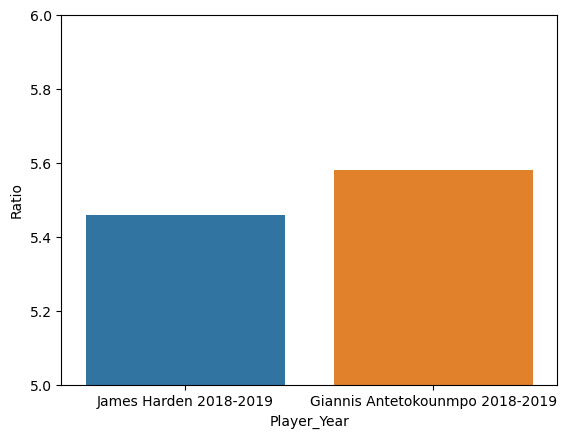

In [712]:
#selecting the rows I need
Harden_2018_2019 = Value_Matrix[(Value_Matrix["Year"] == "2018-2019")&(Value_Matrix["Player"] == "James Harden")]
Giannis_2018_2019 = Value_Matrix[(Value_Matrix["Year"] == "2018-2019")&(Value_Matrix["Player"] == "Giannis Antetokounmpo")]
#creating a column to hold our evaluation
Harden_2018_2019["Ratio"] = (Harden_2018_2019["Eff Score"]/mid_Eff_Score) + (Harden_2018_2019["Raw Score"]/mid_Raw_Score)
Giannis_2018_2019["Ratio"] = (Giannis_2018_2019["Eff Score"]/mid_Eff_Score) + (Giannis_2018_2019["Raw Score"]/mid_Raw_Score)
sns.barplot(Harden_2018_2019, x="Player_Year", y="Ratio")
sns.barplot(Giannis_2018_2019, x="Player_Year", y="Ratio")
plt.ylim(5,6)
plt.show()
#THE DATA IS ASSIGNING CORRECTLY SO IM IGNORING THE WARNING

Giannis gets the MVP. The Ratios are far higher than other comps as well meaning Harden would have won MVP most other years. This gives me an idea for a later comparison...
##### MVP 2018-2019: Giannis Antetokounmpo

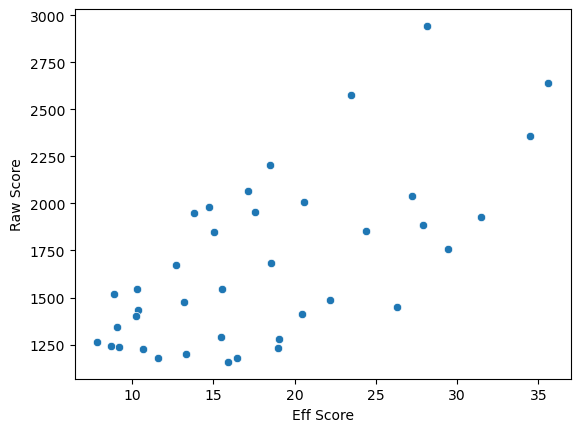

In [696]:
#create a new df to modify and filter for the years we want
Value_Matrix_2019_2020 = Value_Matrix[(Value_Matrix["Year"] == "2019-2020")|(Value_Matrix["Year"] == "2019-2020")]
#plot to visualize where to cut
sns.scatterplot(Value_Matrix_2019_2020, x=Value_Matrix_2019_2020["Eff Score"], y=Value_Matrix_2019_2020["Raw Score"])
plt.show()

Thin chart because of Covid. Cut Eff Score around 23 and 1750 Raw Score

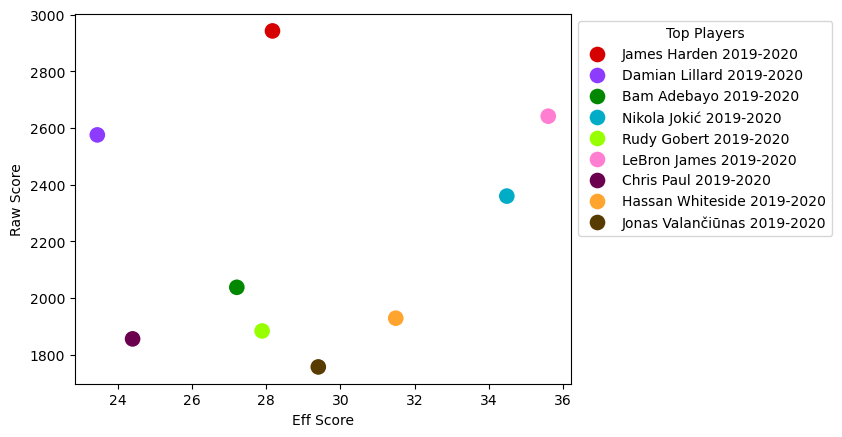

In [706]:
Top_Value_2019_2020 = Value_Matrix_2019_2020[(Value_Matrix_2019_2020["Eff Score"] > 23) & (Value_Matrix_2019_2020["Raw Score"] > 1750)]
palette = sns.color_palette(cc.glasbey, n_colors=9)
sns.scatterplot(Top_Value_2019_2020, x=Top_Value_2019_2020["Eff Score"], y=Top_Value_2019_2020["Raw Score"], hue=Top_Value_2019_2020.index, s=150, palette=palette)
plt.legend(title="Top Players", bbox_to_anchor=(1,1), loc="upper left")
plt.show()

Harden, Jokic, and LeBron all had great years. Lebron's year is clearly better, though, so I'll evaluate Harden vs LeBron (again)

/var/folders/t3/tq1z8cy535bck4xjwkvc0_xh0000gn/T/ipykernel_7622/2938786902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Harden_2019_2020["Ratio"] = (Harden_2019_2020["Eff Score"]/mid_Eff_Score) + (Harden_2019_2020["Raw Score"]/mid_Raw_Score)
/var/folders/t3/tq1z8cy535bck4xjwkvc0_xh0000gn/T/ipykernel_7622/2938786902.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lebron_2019_2020["Ratio"] =(Lebron_2019_2020["Eff Score"]/mid_Eff_Score) + (Lebron_2019_2020["Raw Score"]/mid_Raw_Score)


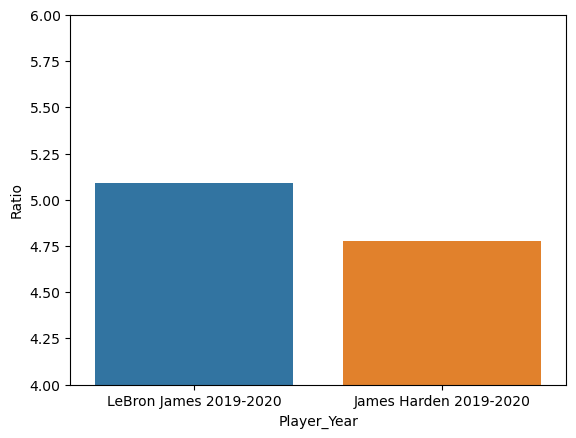

In [711]:
Harden_2019_2020 = Value_Matrix[(Value_Matrix["Year"] == "2019-2020")&(Value_Matrix["Player"] == "James Harden")]
Harden_2019_2020["Ratio"] = (Harden_2019_2020["Eff Score"]/mid_Eff_Score) + (Harden_2019_2020["Raw Score"]/mid_Raw_Score)
Lebron_2019_2020 = Value_Matrix[(Value_Matrix["Year"] == "2019-2020")&(Value_Matrix["Player"]=="LeBron James")]
Lebron_2019_2020["Ratio"] =(Lebron_2019_2020["Eff Score"]/mid_Eff_Score) + (Lebron_2019_2020["Raw Score"]/mid_Raw_Score)
sns.barplot(Lebron_2019_2020, x="Player_Year", y="Ratio")
sns.barplot(Harden_2019_2020, x="Player_Year", y="Ratio")
plt.ylim(4,6)
plt.show()
#THE DATA IS ASSIGNING CORRECTLY SO IM IGNORING THE WARNING

James Harden, always the bridesmaid.

##### MVP 2019-2020: LeBron James 

That is every year from 2000. Some things that stood out to me while I did my EDA:

Kevin Garnett was my favorite player growing up and I was right saying he was underrated

Tracy McGrady and Kevin Love are heavily underrated.

LeBron James is insane.

It seems like when a player wins MVP, they are very likely to win the following year as well. It makes sense. Barring injury, they are the best player and will likely contiinue to be.

Modern players are for more effcient than players from the early 2000's

With all that being said, here is how my matrix performed vs. the MVP voters.

##### 2000-2001: My MVP: Shaquille O'Neal  |  |   NBA MVP: Allen Iverson
##### 2001-2002: My MVP: Tim Duncan   |  |   NBA MVP: Tim Duncan
##### 2002-2003: My MVP: Kevin Garnett   |  |    NBA MVP: Tim Duncan
##### 2003-2004: My MVP: Kevin Garnett   |  |   NBA MVP: Kevin Garnett
##### 2004-2005: My MVP: Kevin Garnett   |  |  NBA MVP: Steve Nash
##### 2005-2006: My MVP: LeBron James    |  |  NBA MVP: Steve Nash
##### 2006-2007: My MVP: Kevin Garnett   |  |   NBA MVP: Dirk Nowitzki
##### 2007-2008: My MVP: LeBron James    |  |  NBA MVP: Kobe Bryant
##### 2008-2009: My MVP: LeBron James    |  |  NBA MVP: LeBron James
##### 2009-2010: My MVP: LeBron James    |  |  NBA MVP: LeBron James
##### 2010-2011: My MVP: LeBron James    |  |  NBA MVP: Derrick Rose
##### 2011-2012: My MVP: LeBron James    |  |  NBA MVP: LeBron James
##### 2012-2013: My MVP: LeBron James    |  |  NBA MVP: LeBron James
##### 2013-2014: My MVP: Kevin Love   |  |   NBA MVP: Kevin Durant
##### 2014-2015: My MVP: Russell Westbrook    |  |   NBA MVP: Stephen Curry
##### 2015-2016: My MVP: Russell Westbrook    |  |   NBA MVP: Stephen Curry
##### 2016-2017: My MVP: Russell Westbrook   |  |    NBA MVP: Russell Westbrook
##### 2017-2018: My MVP: LeBron James    |  |   NBA MVP: James Harden
##### 2018-2019: My MVP: Giannis Antetokounmpo  |  |  NBA MVP:Giannis Antetokounmpo
##### 2019-2020: My MVP: LeBron James  |  |   NBA MVP: Giannis Antetokounmpo
##### 2020-2021: My MVP: Nikola Jokic  |  |    NBA MVP: Nikola Jokic
##### 2021-2022: My MVP: Nikola Jokic   |  |    NBA MVP: Nikola Jokic
##### 2022-2023: My MVP: Nikola Jokic  |  |   NBA MVP: Joel Embiid
##### 2023-2024: My MVP: Nikola Jokic  |  |     NBA MVP: Nikola Jokic

Overall my matrix indetified the actual MVP 11 out of 25 times. Under a 50% success rate. This does not bode well for this evaluations efficacy. However, I do believe my analysis was sound and some other factor are at play. First, voter fatigue does exist. Humans vote on the MVP and no one wants to see the same player win 6 straight MVPs. Therefore, even though LeBron was statistically better each season he would never win every year. We see the same effect happening now with Nikola Jokic.  We can't really adjsut for this statistically though. Secondly, I believe a players teammates greatly affect perception on individual value. Allen Iverson and Dirk Nowitzki both had weak teams they led to success which boosted their 'value' in the eyes of voters. Lastly, my current matrix may need to be weighted to better account for a factor I am missing.

The next steps to producing true value would be to evaluate the teammates each player played with and adjusting the numbers to reflect how much more value the player produced compared to the rest of the team. Than look at the teams overall record to see if it produced ‘winning basketball’. A player who produced far more than any teammate and lead the team to a top record should be considered when evaluating “value”, even if their raw numbers may be lacking.
